# Study Course Deep Learning MC1 - Image Classification

**Author:** Simon Staehli / 5Da

## Use-Case

Für diese Mini-Challenge habe ich ein eigenen Datensatz zusammengestellt aus diversen Bilder, welche mit Klassen gelabelt sind.
Der Datensatz besteht aus ca. 29'000 Bilder und 28 Labels. 1000 Bilder pro Label. Die Daten habe ich von der folgenden Webseite kollektiert: https://500px.com/. Das Ziel ist es nun die Bilder anhand dieser Labels richtig zu labeln. Dies möchte ich anhand eines CNN-Models erreichen. Im Nachfolgenden werde ich verschiedene Modelle, Optimizer, Regularisierungsmethoden vergleichen. Ausserdem werde ich Transfer-Learning anhand eines vortraininerten Neuronalen Netzes verwenden, dass auf einem weitaus grösseren Datensatz vortrainiert wurde, wie z.B. ImageNet.


In [1]:
import sys
import os
import shutil
import numpy as np
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import random
import seaborn as sns
import pandas as pd
import pickle

from multiprocess import Pool
from helper import *

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix

## Vorbereitung des Datensatzes

### Generierung Datensatz für Train-Test-Split

Nun werde ich nachfolgend basierend auf meinen gesammelten Daten eine neue Ordnerstruktur generieren, ein Train-Test Split Erstellen und als Dictionary speichern und das Dictionary vorbereiten für das Kopieren der Bilder in einen Neuen Ordner mit Multiprocessing.

In [4]:
curr_img_path = "images"
new_img_path = "data"
train_size = 0.9

In [5]:
process_image_folder = False

if process_image_folder:
    image_splits = generate_train_test_from_folder(
        img_path=curr_img_path, train_size=train_size
    )
    create_train_test_folder(split_dict=image_splits, fp_new_folder=new_img_path)
    fp_from_to = prepare_img_splits(split_dict=image_splits, new_fp=new_img_path)

In [6]:
# Remove corrupted images
if process_image_folder:
    drop_corrupted_images(image_paths=fp_from_to)

Hier kopiere ich alle Files in den neuen Ordner mit Multiprocessing

In [7]:
if process_image_folder:
    copy_all_files(fp_from_to=fp_from_to, n_proc=4)

----------

# Convolutional Neural Netowork

## Theorie



## DataLoader

Zuerst muss ich einige Preprozessierungsschritte bei der Bearbeitung der Bilder vornehmen. Dafür verwende ich die Klasse `Compose` von torchvision. Torchvision beinhaltet auch Schritte, die auf Bilder angewendet werden können. Für meine Bilder verwende ich: `Resize, CenterCrop, ToTensor` in dieser Reihenfolge.

In [8]:
# Define a Composal of image transformation used for image load
transform_images = Compose([Resize((128, 128)), 
                            ToTensor()])

In [9]:
train_data = ImageFolder("data/train", transform=transform_images)
test_data = ImageFolder("data/test", transform=transform_images)

In [10]:
label_translator = dict(
    zip([*train_data.class_to_idx.values()], [*train_data.class_to_idx.keys()])
)
label_translator

{0: 'abstract',
 1: 'aerial',
 2: 'animals',
 3: 'black and white',
 4: 'celebrities',
 5: 'city and architecture',
 6: 'commercial',
 7: 'concert',
 8: 'family',
 9: 'fashion',
 10: 'film',
 11: 'fine art',
 12: 'food',
 13: 'journalism',
 14: 'landscapes',
 15: 'macro',
 16: 'nature',
 17: 'night',
 18: 'people',
 19: 'performing arts',
 20: 'sport',
 21: 'still life',
 22: 'street',
 23: 'transportation',
 24: 'travel',
 25: 'underwater',
 26: 'urban exploration',
 27: 'wedding'}

In [11]:
# Test size
train_size = len(train_data.targets) / (
    len(train_data.targets) + len(test_data.targets)
)
print("Train Size in Folder: ", train_size)

Train Size in Folder:  0.8995574437953621


In [12]:
dataloader_train = DataLoader(train_data, batch_size=128, shuffle=True, 
                              num_workers=24, pin_memory=True)
dataloader_test = DataLoader(test_data, batch_size=128, shuffle=True, 
                             num_workers=24, pin_memory=True)

C:\Users\simon\anaconda3\envs\GPU_Pytorch\lib\site-packages\torch\utils\data\dataloader.py:478: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
# Plot some images
images, labels = next(iter(dataloader_train))

In [14]:
def plot_images_from_loader(
    images_from_loader: list, labels: list, amount: int, **args
):
    """"""
    plot_idx = np.random.permutation(np.arange(0, len(images_from_loader)))[:amount]
    plot_images = images_from_loader[plot_idx]
    plot_images = [to_pil_image(img) for img in plot_images]
    plot_images_labels = labels[plot_idx]

    ncol = args.get("ncol", None) if args.get("ncol", None) else 5
    nrow = int(amount / ncol) + 1
    fig = plt.subplots(figsize=(20, 4 * nrow))
    for i, img_label in enumerate(zip(plot_images, plot_images_labels)):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(img_label[0])
        plt.title(
            f"Label: {img_label[1].tolist()} / {label_translator[img_label[1].tolist()]}"
        )
    plt.show()

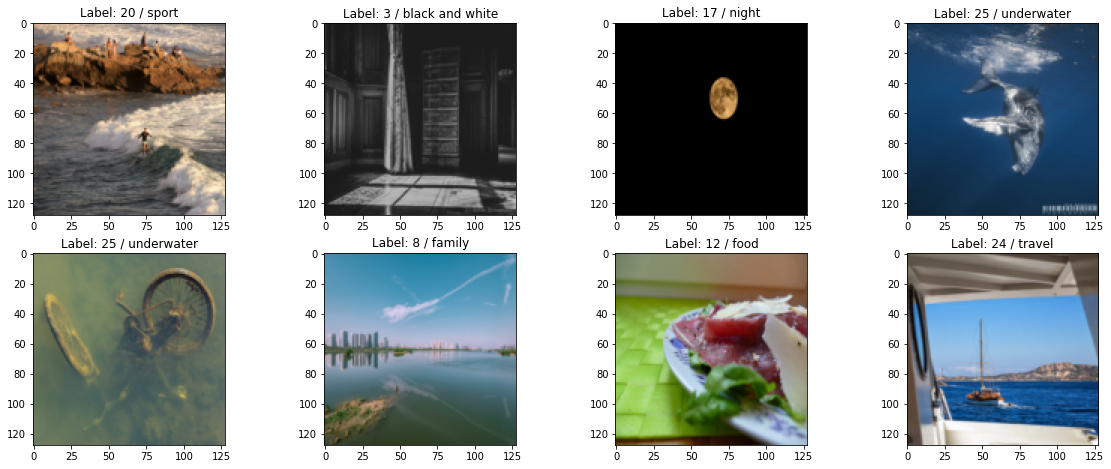

In [15]:
plot_images_from_loader(images_from_loader=images, labels=labels, amount=8, ncol=4)

Man kann nun sehen, dass alle Bilder die gleiche Grösse haben und ähnlich aussehen. Das Preprocessing mit Pytorch hat funktioniert. 

Nun werde ich den gleichen Schritt nochmals wiederholen, nur werde ich noch eine Normalisierung des Tensors anfügen.

In [ ]:
# Define a Composal of image transformation used for image load
transform_images = Compose([Resize((128, 128)), 
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
train_data = ImageFolder("data/train", transform=transform_images)
test_data = ImageFolder("data/test", transform=transform_images)

In [ ]:
print("GPU available: ", torch.cuda.is_available())

In [ ]:
class Net(nn.Module):
    def __init__(self, n_classes, in_channels=3):
        """Initialization of the Network"""
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=(8,8), stride=4)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=(8,8), stride=4)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=n_classes)

    def forward(self, x):
        """Forward Prop"""
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
example = next(iter(dataloader_train))[0]
_ = Net(n_classes=28, in_channels=3).forward(x=example)

In [ ]:
model = Net(n_classes=28)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.01, momentum=.95)
dtype = torch.float32

In [ ]:
# Send to gpu
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(dev)
criterion.to(dev)

In [ ]:
def train_net(n_epoch):  # Training our network
    losses = []
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    model.train()
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        with tqdm(total=len(dataloader_train)) as pbar:
            for data in dataloader_train:
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs, labels = inputs.to(dev), labels.to(dev)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                losses.append(loss)
                running_loss += loss.item()
                train_acc = torch.sum(torch.max(outputs) == labels)
                pbar.update(1)
                pbar.set_description(f'Epoch: {epoch+1} // Running Loss: {running_loss} ')
    return losses

def test_loop():
    pass

def train_loop():
    pass

In [ ]:
torch.cuda.empty_cache()

In [ ]:
losses = train_net(n_epoch=10)

In [ ]:
def plot_loss(losses, sma=5, fig_title=''):
    l = pd.Series([l.item() for l in losses][2:])
    plt.subplots(figsize=(12, 5))
    p = sns.lineplot(x=np.arange(len(l)), y=l)
    p = sns.lineplot(x=np.arange(len(l)), y=l.rolling(sma).mean(), label=f'SMA {sma}')
    plt.title(fig_title, fontsize=10)
    plt.suptitle('Loss over Epochs Splitted into Batches')
    p.set_xlabel('Batches')
    p.set_ylabel('Loss')
    sns.despine()
    plt.show()

In [ ]:
plot_loss(losses, 50)

**Beschreibung:**

Man kann hier sehen, dass der Loss über die Epochen hinweg auf dem Trainingset immer mehr abnimmt. Dies grunsätzlich ein gutes Zeichen und zeigt, dass die Trainingsdaten iterativ immer besser gefittet werden. Da wir hier basierend auf mehreren kleineren `Batches` optimieren, sieht die Kostenfunktino auch so verrauscht aus.

In [ ]:
# Calculate Acc on Train set
def calculate_accuracy(dl_train, dl_test, model):
    """
    """
    model.eval()
    with torch.no_grad():
        y_pred_train = []
        y_true_train = []
        for batch in tqdm(dl_train, desc='Calculate Acc. on Train Data'):
            images, labels = batch
            images, labels = images.to(dev), labels.to(dev)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred_train = np.append(y_pred_train, predicted.cpu().numpy())
            y_true_train = np.append(y_true_train, labels.cpu().numpy())

    # On testset
    with torch.no_grad():
        y_pred = []
        y_true = []
        for batch in tqdm(dl_test, desc='Calculate Acc. on Test Data'):
            images, labels = batch
            images, labels = images.to(dev), labels.to(dev)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred = np.append(y_pred, predicted.cpu().numpy())
            y_true = np.append(y_true, labels.cpu().numpy())
            
    train_acc = np.round(np.sum(y_pred_train == y_true_train)/len(y_pred_train), 3)
    test_acc = np.round(np.sum(y_pred == y_true)/len(y_pred), 3)
    
    return (train_acc, test_acc)

In [ ]:
train_accuracy, test_accuracy = calculate_accuracy(dl_train=dataloader_train, dl_test=dataloader_test, model=model)
print('Train Accuracy: ', train_accuracy)
print('Test Accuracy: ', test_accuracy)

In [ ]:
plt.subplots(figsize=(14, 8))

p = sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), cmap='Blues',
               xticklabels=label_translator.values(), yticklabels=label_translator.values())

p.set_title('Confusion Matrix', loc='left')
p.set_xlabel('Predicted')
p.set_ylabel('True')

plt.show()

**Beschreibung:**

.....


## AlexNet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, n_classes):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=n_classes)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Define a Composal of image transformation used for image load
transform_images = Compose([Resize((227, 227)), 
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
train_data = ImageFolder("data/train", transform=transform_images)
test_data = ImageFolder("data/test", transform=transform_images)

In [ ]:
dataloader_train = DataLoader(train_data, batch_size=150, shuffle=True, 
                              num_workers=24, pin_memory=True)
dataloader_test = DataLoader(test_data, batch_size=150, shuffle=True, 
                             num_workers=24, pin_memory=True)

### Comparisson of Different OPtimizers

In [ ]:
optimizer_loss = {}
optimizer_acc = {}

In [ ]:
seed = 42
torch.cuda.manual_seed(42)
model = AlexNet(n_classes=28)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.01, momentum=.98)
dtype = torch.float32

In [ ]:
# Send to gpu
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(dev)
criterion.to(dev)

In [ ]:
losses = []
n_epochs = 10
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.train()
for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    with tqdm(total=len(dataloader_train)) as pbar:
        for data in dataloader_train:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(dev), labels.to(dev)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            losses.append(loss)
            running_loss += loss.item()
            train_acc = torch.sum(torch.max(outputs) == labels)
            pbar.update(1)
            pbar.set_description(f'Epoch: {epoch+1} // Running Loss: {running_loss} ')
            
optimizer_loss['SGD'] = {'loss': [l.item() for l in losses]}

In [ ]:
train_accuracy, test_accuracy = calculate_accuracy(dl_train=dataloader_train, dl_test=dataloader_test, model=model)
optimizer_loss['SGD']['acc_train'] = train_accuracy
optimizer_loss['SGD']['acc_test'] = test_accuracy
print('Train Accuracy: ', train_accuracy)
print('Test Accuracy: ', test_accuracy)

In [ ]:
plot_loss(losses, 10, fig_title=f'Loss Function: Cross-Entropy / Optimizer: SGD')

In [ ]:
seed = 42
torch.cuda.manual_seed(42)
model = AlexNet(n_classes=28)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)
dtype = torch.float32

In [ ]:
# Send to gpu
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(dev)
criterion.to(dev)

In [ ]:
losses = []
n_epochs = 10
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.train()
for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    with tqdm(total=len(dataloader_train)) as pbar:
        for data in dataloader_train:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(dev), labels.to(dev)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            losses.append(loss)
            running_loss += loss.item()
            train_acc = torch.sum(torch.max(outputs) == labels)
            pbar.update(1)
            pbar.set_description(f'Epoch: {epoch+1} // Running Loss: {running_loss} ')
            
optimizer_loss['Adam'] = {'loss': [l.item() for l in losses]}

In [ ]:
train_accuracy, test_accuracy = calculate_accuracy(dl_train=dataloader_train, dl_test=dataloader_test, model=model)
optimizer_loss['Adam']['acc_train'] = train_accuracy
optimizer_loss['Adam']['acc_test'] = test_accuracy
print('Train Accuracy: ', train_accuracy)
print('Test Accuracy: ', test_accuracy)

In [ ]:
plot_loss(losses, 10, fig_title=f'Loss Function: Cross-Entropy / Optimizer: Adam')

In [ ]:
seed = 42
torch.cuda.manual_seed(42)
model = AlexNet(n_classes=28)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=2)
dtype = torch.float32

In [ ]:
# Send to gpu
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(dev)
criterion.to(dev)

In [ ]:
losses = []
n_epochs = 10
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.train()
for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    with tqdm(total=len(dataloader_train)) as pbar:
        for data in dataloader_train:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(dev), labels.to(dev)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            losses.append(loss)
            running_loss += loss.item()
            train_acc = torch.sum(torch.max(outputs) == labels)
            pbar.update(1)
            pbar.set_description(f'Epoch: {epoch+1} // Running Loss: {running_loss} ')
            
optimizer_loss['RMSprop'] = {'loss': [l.item() for l in losses]}

In [ ]:
train_accuracy, test_accuracy = calculate_accuracy(dl_train=dataloader_train, dl_test=dataloader_test, model=model)
optimizer_loss['RMSprop']['acc_train'] = train_accuracy
optimizer_loss['RMSprop']['acc_test'] = test_accuracy
print('Train Accuracy: ', train_accuracy)
print('Test Accuracy: ', test_accuracy)

In [ ]:
plot_loss(losses, 10, fig_title=f'Loss Function: Cross-Entropy / Optimizer: RMSProp')

In [ ]:
with open('optimizer_loss.pkl', 'wb') as pkl_file:
    pickle.dump(optimizer_loss, pkl_file)
    
with open('optimzer_acc.pkl', 'wb') as pkl_file:
    pickle.dump(optimizer_acc, pkl_file)

In [ ]:
optimizer_loss

# Sources

Optimizers: https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a

https://theaisummer.com/cnn-architectures/

https://paperswithcode.com/methods/category/convolutional-neural-networks

https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d

Deep Learning with Pytorch Book

Sebastian Rashka 13-14 - Convolutional Networks

https://towardsdatascience.com/how-to-apply-a-cnn-from-pytorch-to-your-images-18515416bba1

https://www.youtube.com/watch?v=bNb2fEVKeEo&ab_channel=StanfordUniversitySchoolofEngineering